# Case-Control Finder  
## Finds cases and controls for a given condition within the Sequence Read Archive

__1. Create sets of matched case and control samples__ 

First, set the query-parameters and output filenames below:

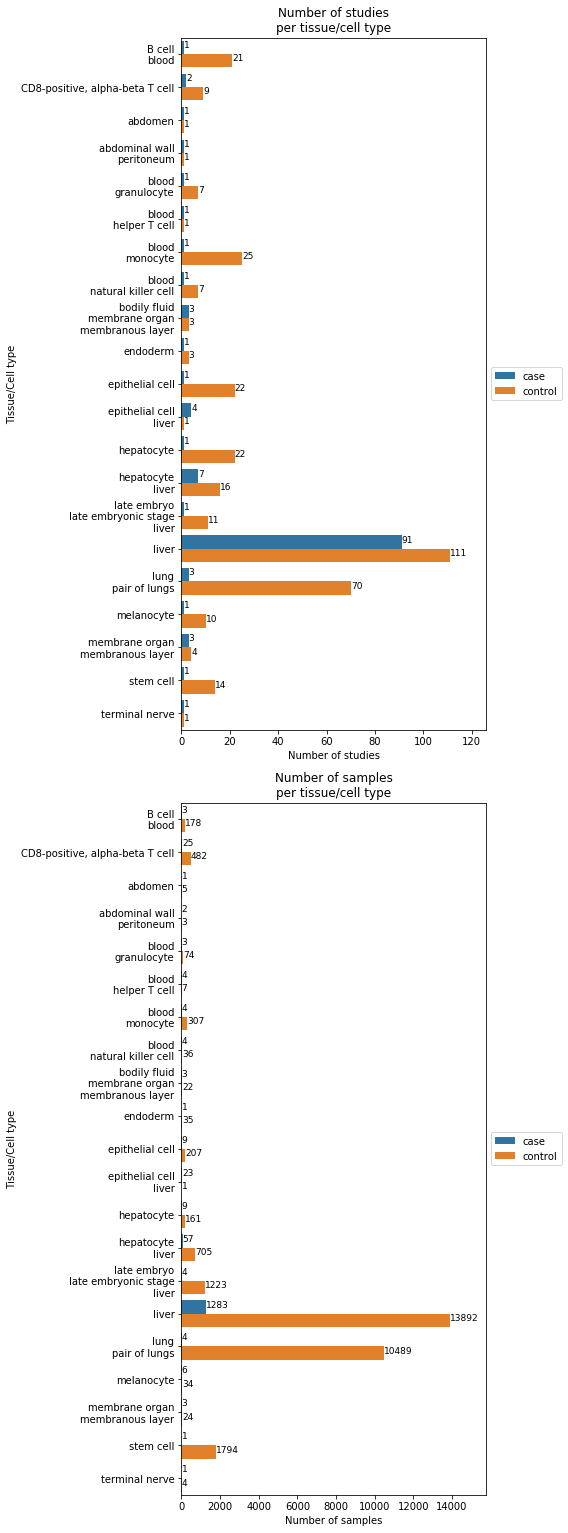

In [20]:
# Enter the case term you are looking for (in place of "liver cancer").
# This can also be a term ID within the Disease ontology (e.g. "DOID:3571")
# or Experimental Factors Ontology (e.g. "EFO:1001513"). To search the
# ontologies for terms, one can use the Ontology Lookup Service: 
# https://www.ebi.ac.uk/ols/index

CONDITION = "liver cancer"                               ## <-- INPUT HERE


# If True, remove diseased samples from the controls.

FILTER_DISEASE_CONTROL = True                      ## <-- INPUT HERE


# Remove experimentally treated samples from the results. 

FILTER_TREATED = False                             ## <-- INPUT HERE


# If True, in vitro differentiated samples from the results

FILTER_IN_VITRO_DIFFERENTIATED_CELLS = True        ## <-- INPUT HERE


# If True, remove cell line samples from the results

FILTER_CELL_LINE = False                           ## <-- INPUT HERE


# If True, match samples by sex 

MATCH_BY_SEX = False                                ## <-- INPUT HERE


# If True, match samples by age (in years). We note that 
# age is sparsely annotated in the SRA and thus, setting this 
# to True, will likely result in fewer results.

MATCH_BY_AGE = False                               ## <-- INPUT HERE


# Name of file storing the query results

OUTPUT_FILE = 'cases_vs_controls.tsv'             ## <-- INPUT HERE


# Filename for which to save the barplots that  

SAVE_FIGURE = 'liver.png'                         ## <-- INPUT HERE


###################### Generate datasets #############################
import json
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from utils import *

r = load_metadata(None)
sample_to_all_terms = r[0]
sample_to_ms_terms = r[1]
term_name_to_id = r[2]
term_id_to_name = r[3]
sample_to_type = r[4]
sample_to_study = r[5]
sample_to_runs = r[6]
sample_to_real_val = r[7]

# Finds candidate case and control samples
case, control = term_to_samples(
    sample_to_all_terms, 
    term_id_to_name, 
    CONDITION
)

# Matches the cases to controls
ret = match_case_to_controls(
    CONDITION, 
    control, 
    case, 
    sample_to_ms_terms,
    sample_to_real_val,
    sample_to_study, 
    term_name_to_id, 
    sample_to_type,
    filter_poor=True, 
    filter_disease=FILTER_DISEASE_CONTROL, 
    filter_cell_line=FILTER_CELL_LINE,
    filter_treated=FILTER_TREATED,
    filter_differentiated=FILTER_IN_VITRO_DIFFERENTIATED_CELLS,
    match_sex=MATCH_BY_SEX,
    match_age=MATCH_BY_AGE,
    sample_to_runs=sample_to_runs, 
    by_run=False
)
df = ret[0]
control_confound = ret[1]
case_confound = ret[2]
tissue_intersections = ret[3]

# Generate summary figures
if df.shape[0] == 0:
    #print('No results were found. Please try another search.')
    print("\x1b[31mNo results were found. Please try another search.\x1b[0m")
else:
    create_summary_plots(df)
    if SAVE_FIGURE is not None:
        plt.savefig(SAVE_FIGURE, format='png', dpi=150)
    plt.show()
    
# Save results
df.to_csv(OUTPUT_FILE, sep='\t')

__2. Browse other metadata terms that are associated with cases and controls.__ 

Explore the fraction of samples associated with other attributes (showing the top 10 attributes). It asl plots the fraction of samples belonging to potentially relevant, yet broad, biological categories.To save the figure, enter the name of the file to store the figure.

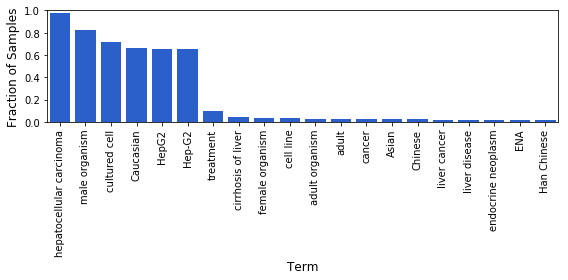

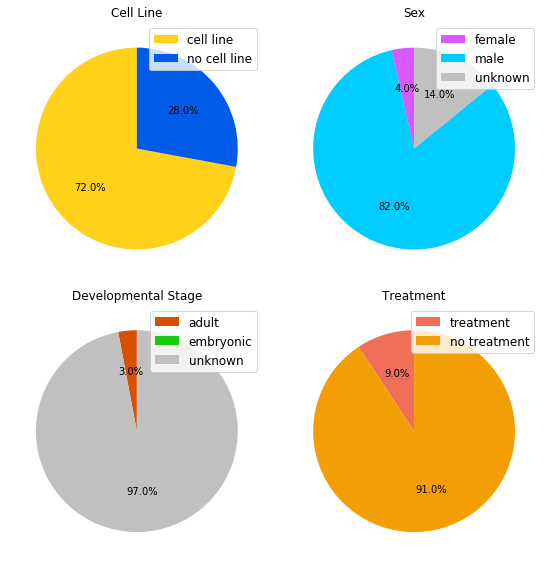

In [21]:
# Enter whether you want to view cases or controls. Assign the 
# following variable to True to view cases or 'False' to view 
# controls.

VIEW_CASES = True                               ## <-- INPUT HERE


# Enter the tissue or cell type on which to subset your samples. For 
# a combination of tissues/cell types, separate each tissue/cell type 
# with a comma. For example ``brain,neuron``. Enter ``None`` to avoid 
# subsetting. 

TERM = 'liver'                                  ## <-- INPUT HERE


# Filename of the bargraph showing other associated attributes

SAVE_BARGRAPH_FIGURE = 'liver_co_terms.png'     ## <-- INPUT HERE


# Filename of the pie charts showing fraction of samples belonging
# to potentially relevant, yet broad, biological categories.

SAVE_PIEGRAPH_FIGURE = 'liver_pie.png'          ## <-- INPUT HERE



######################## Generate figures ############################

err_msg = create_barplot_most_common_coterms_match(
    df, 
    VIEW_CASES, 
    TERM, 
    sample_to_ms_terms
)
if err_msg is None:
    if SAVE_FIGURE is not None:
        plt.tight_layout()
        plt.savefig(SAVE_BARGRAPH_FIGURE, bbox_inchesstr='tight', dpi=150)
    plt.show()
    create_pie_charts_matched(
        df, 
        VIEW_CASES, 
        TERM, 
        sample_to_ms_terms
    )
    if SAVE_FIGURE is not None:
        plt.tight_layout()
        plt.savefig(SAVE_PIEGRAPH_FIGURE, bbox_inchesstr='tight', dpi=150)
    plt.show()
else:
    print("\x1b[31m{}\x1b[31m".format(err_msg))

